# Applying algebra to regression models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import seaborn as sns
from scipy import stats
from scipy.stats import yeojohnson
import statsmodels.formula.api as smf

talk = False
online = True
if talk:
    sns.set(context="talk", style="darkgrid")
    figdir = "talk-figures/"
    dpi = 96
else:
    sns.set(context="paper", style="whitegrid")
    figdir = "figures/"
    dpi = 140

In [2]:
def linear(x, slope, y_intercept):
    return x * slope + y_intercept


def exponential(X, a, b):
    return a * np.exp(b * X)

# Misstep 1: Applying algebra to random variables

### Example: Winland equation

The Winland equation is written in the form
$$ \ln r = A \ln k + B \ln\phi + C$$
where $r$ is the pore throat size (often the 35th percentile), $k$ is the permeability, and $\phi$ is the porosity. It was designed to predict pore throat size from nondestructive core tests, and the parameters $A, B, C$ have been calculated for many different sandstones using the regression
$$ \ln r \sim A \ln k + B \ln\phi + C + \epsilon $$
where $\epsilon$ captures the residual and is expected to be normal.

Some well-meaning engineers have used the regression results to recast the equation as
$$ \ln k = \frac{\ln r + B \ln\phi + C}{A}$$
under the reasoning that $r$ and $\phi$ are physically measurable rock properties that cause permeability. Pore throat size is then related to some petrophysical or textural interpretation to predict permeability. Unfortunately, this neglects the importance of the error term and leads to erroneous results.

Below, we show the effect of this mistake, comparing the results of algebraically manipulating a regression on $r$ to predict $k$, and simply regressing on $k$, as illustrated by the regressions Pittman (1992) performed

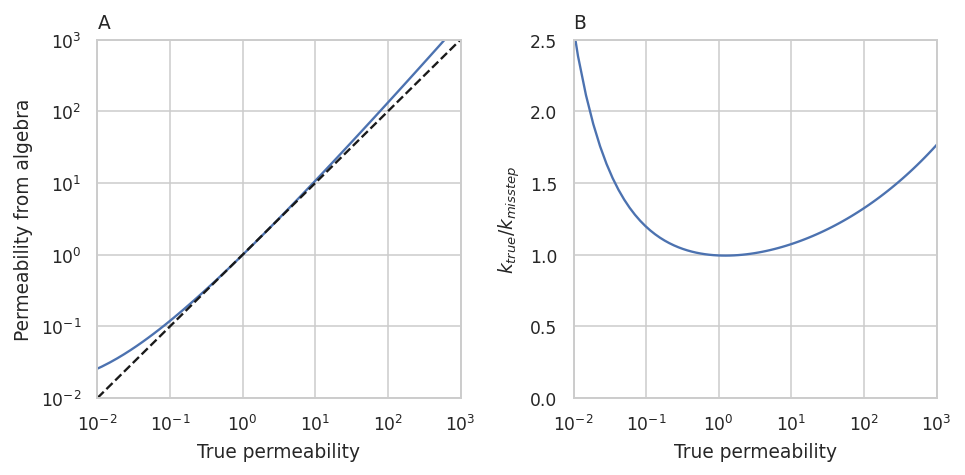

In [3]:
# Figure 3
rng = np.random.default_rng(seed=174)
if talk:
    figsize = (10, 5)
else:
    figsize = (7, 3.5)

phi = np.linspace(0.5, 33, 100)
permeability = np.power(10, 0.174 * phi - 1.88)
r_p = np.power(10, 0.531 * np.log10(permeability) - 0.350 * np.log10(phi) + 0.204)
permeability_eq9b = np.power(10, 1.512 * np.log10(r_p) + 1.415 * np.log10(phi) - 1.221)
permeability_eq9c = np.power(10, 1.88 * np.log10(r_p) + 0.659 * np.log10(phi) - 0.384)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax1.loglog(permeability_eq9b, permeability_eq9c)
ax1.plot([0, 1e3], [0, 1e3], "--k")
ax1.set(
    xlabel="True permeability",
    xlim=(0.01, 1000),
    ylabel="Permeability from algebra",
    ylim=(0.01, 1000),
)
ax1.set_title("A", loc="left")

ax2.semilogx(permeability_eq9b, permeability_eq9c / permeability_eq9b)
ax2.set(
    xlabel="True permeability",
    xlim=(0.01, 1000),
    ylabel="$k_{true}/k_{misstep}$",
    ylim=(0, 2.5),
)
ax2.set_title("B", loc="left")
plt.tight_layout()

Using algebra on the regression result leads to overpredicting permeability. At low permeabilities, typical among tight sands, the result can be twice as large as the true permeability. 

This has clear implications when it comes to pay cutoffs. Mis-applying the Winland equation in this way leads to non-pay reservoir being considered pay, with disappointing results.

#### A synthetic example

Next, we have a synthetic example to see how this effect manifests itself. Porosity is drawn from a random distribution, then permeability from a relation similar to the measurements made by Kwon and Pickett (1975), with a random stochastic noise added. Finally, pore throat size is generated from Pittman's equation, also with a random stochastic noise.

Figure 4A shows the porosity-permeability relationship from this method, while Figure 4B shows the relationship between $k/\phi$ and $r$. By the time the Winland equation is round tripped back to permeability, we can see that the scatter between true and predicted permeability has become quite large (the last figure).

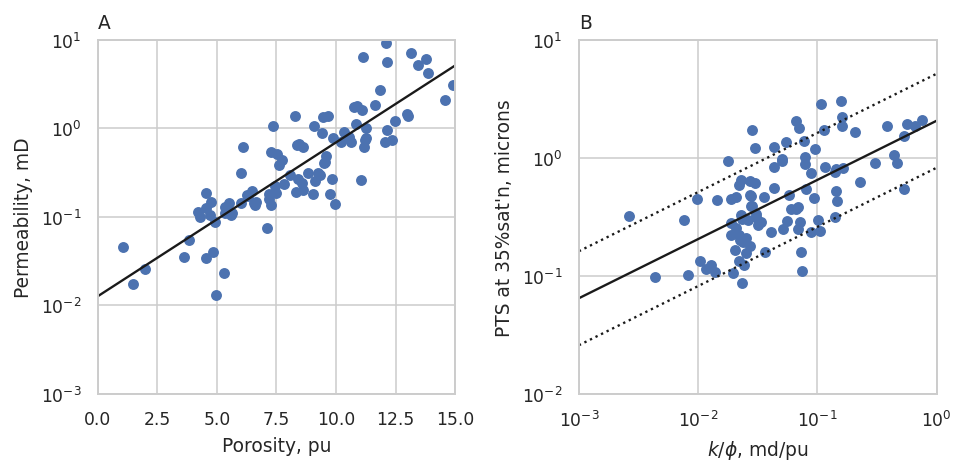

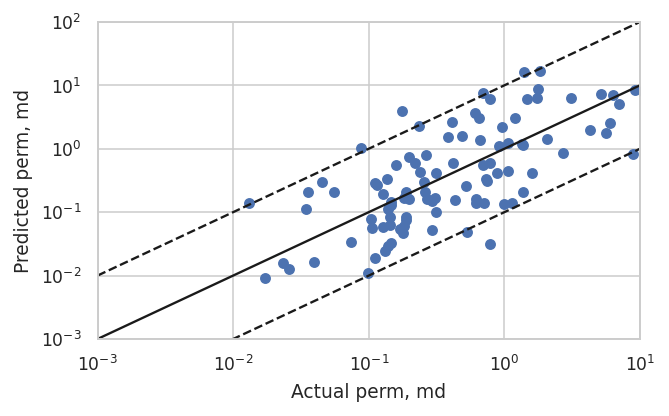

In [4]:
# Figures 4 and 5
if talk:
    figsize = (10, 5)
    figsize2 = (7, 5)
    dpi = 96
else:
    figsize = (7, 3.5)
    figsize2 = (5, 3)
    dpi = 140
rng = np.random.default_rng(seed=174)

porosity = rng.normal(9, 3, 100)
err = rng.normal(0, 0.3, 100)
err2 = rng.normal(0, 0.3, 100)
permeability = np.power(10, 0.174 * porosity - 1.88 + err)
# a, b, c = 0.588, -0.864, 0.732  # Kolodzie
(
    a,
    b,
    c,
) = (
    0.531,
    -0.350,
    0.204,
)  # Pittman
log_pore_throat_size = a * np.log10(permeability) + b * np.log10(porosity) + c + err2
pore_throat_size = np.power(10, log_pore_throat_size)

porosity_line = np.array([0.01, 15])
(slope, y_intercept), _ = optimize.curve_fit(linear, porosity, np.log(permeability))
perm_pred = np.exp(linear(porosity_line, slope, y_intercept))

k_phi_line = np.array([1e-3, 1])
(slope, y_intercept), _ = optimize.curve_fit(
    linear, np.log(permeability / porosity), np.log(pore_throat_size)
)
pts_pred = np.exp(slope * np.log(k_phi_line) + y_intercept)

permeability_predicted = np.power(
    10, 1.88 * np.log10(pore_throat_size) + 0.659 * np.log10(porosity) - 0.384
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax1.scatter(porosity, permeability)
ax1.plot(porosity_line, perm_pred, "k-")
ax1.set(
    xlabel="Porosity, pu",
    xlim=(0, 15),
    ylabel="Permeability, mD",
    yscale="log",
    ylim=(0.001, 10),
)
if not talk:
    ax1.set_title("A", loc="left")

ax2.scatter(permeability / porosity, pore_throat_size)
ax2.plot(k_phi_line, pts_pred, "-k")
ax2.plot(k_phi_line, pts_pred * 2.5, ":k")
ax2.plot(k_phi_line, pts_pred / 2.5, ":k")
ax2.set(
    xlabel=r"$k/\phi$, md/pu",
    xscale="log",
    xlim=(0.001, 1),
    ylabel="PTS at 35%sat'n, microns",
    yscale="log",
    ylim=(0.01, 10),
)
if not talk:
    ax2.set_title("B", loc="left")
plt.tight_layout()

fig, ax = plt.subplots(figsize=figsize2, dpi=dpi)
ax.scatter(permeability, permeability_predicted)
ax.set(
    xlabel="Actual perm, md",
    xscale="log",
    xlim=(0.001, 10),
    ylabel="Predicted perm, md",
    yscale="log",
    ylim=(0.001, 100),
)
ax.plot([0, 10], [0, 10], color="k")
ax.plot([1e-3, 10], [1e-2, 100], "--k")
ax.plot([1e-3, 10], [1e-4, 1], "--k")